In [253]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Preprocessing and data exploring

In [254]:
# Read in the data
ticker_headers = pd.read_csv("Data/data.csv", skiprows=3, nrows=1, header=None).iloc[0, 1:].tolist()

df = pd.read_csv("Data/data.csv", header=5)

# preprocess data
new_columns = df.columns.tolist()
new_columns[1:] = ticker_headers
df.columns = new_columns

# Date to datetime object
df['Dates'] = pd.to_datetime(df['Dates'])
df.set_index('Dates', inplace=True)

# handle missing values
df.ffill(inplace=True)

# Save new df to csv
df.to_csv("Data/processed_data.csv")


In [255]:
print("Dataframe head:")
df.head()

Dataframe head:


,SPTR Index,MOVE Index,VIX Index,XAU Curncy,USGG10YR Index,DXY Curncy
Dates,,,,,,
2010-01-01,1837.499,107.5,21.68,1097.35,3.8350,77.860
2010-01-04,1867.063,106.4,20.04,1121.28,3.8155,77.525
2010-01-05,1872.896,102.5,19.35,1118.05,3.7608,77.619
2010-01-06,1874.729,106.9,19.16,1138.25,3.8215,77.493
2010-01-07,1882.344,104.4,19.06,1131.75,3.8235,77.913


In [256]:
print("Dataframe tail:")
df.tail()

Dataframe tail:


,SPTR Index,MOVE Index,VIX Index,XAU Curncy,USGG10YR Index,DXY Curncy
Dates,,,,,,
2025-04-25,12178.492,105.79,24.84,3319.72,4.2353,99.471
2025-04-28,12186.517,110.01,25.15,3343.98,4.2082,99.010
2025-04-29,12257.272,112.27,24.17,3317.41,4.1716,99.237
2025-04-30,12276.393,112.48,24.70,3288.71,4.1619,99.468
2025-05-01,12353.874,107.33,24.60,3239.20,4.2176,100.248


In [257]:
print("Dataframe info:")
df.info()

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4000 entries, 2010-01-01 to 2025-05-01
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SPTR Index      4000 non-null   float64
 1   MOVE Index      4000 non-null   float64
 2   VIX Index       4000 non-null   float64
 3   XAU Curncy      4000 non-null   float64
 4   USGG10YR Index  4000 non-null   float64
 5   DXY Curncy      4000 non-null   float64
dtypes: float64(6)
memory usage: 218.8 KB


In [258]:
df.describe()

,SPTR Index,MOVE Index,VIX Index,XAU Curncy,USGG10YR Index,DXY Curncy
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,5611.076643,79.325351,18.427200,1576.204560,2.533053,92.483275
std,3093.630369,25.085366,6.966899,405.069683,0.964261,9.485983
min,1701.857000,36.620000,9.140000,1051.100000,0.506900,72.933000
25%,3147.033250,59.017250,13.630000,1263.830000,1.834550,82.270500
50%,4785.532500,74.390000,16.640000,1473.215000,2.396300,94.688500
75%,8210.416500,95.360100,21.230000,1801.797500,3.098500,99.138500
max,13510.289000,198.710000,82.690000,3423.980000,4.989800,114.106000


I could not detect any anomalies in the data. data does not have any missing values neither any outliers or negative values.

Just to be 100% sure, lets check if all business days are present in the data.

In [259]:
# Checking date range from the first to the last date in the DataFrame, frequency 'B' (business days)
expected_business_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='B')

missing_business_dates = expected_business_dates.difference(df.index)

if missing_business_dates.empty:
    print("All business days are present in the data.")
else:
    print("Missing business days:", missing_business_dates)

All business days are present in the data.


Producing rolling 21-day volatility plot and a 126-day correlation heat map.

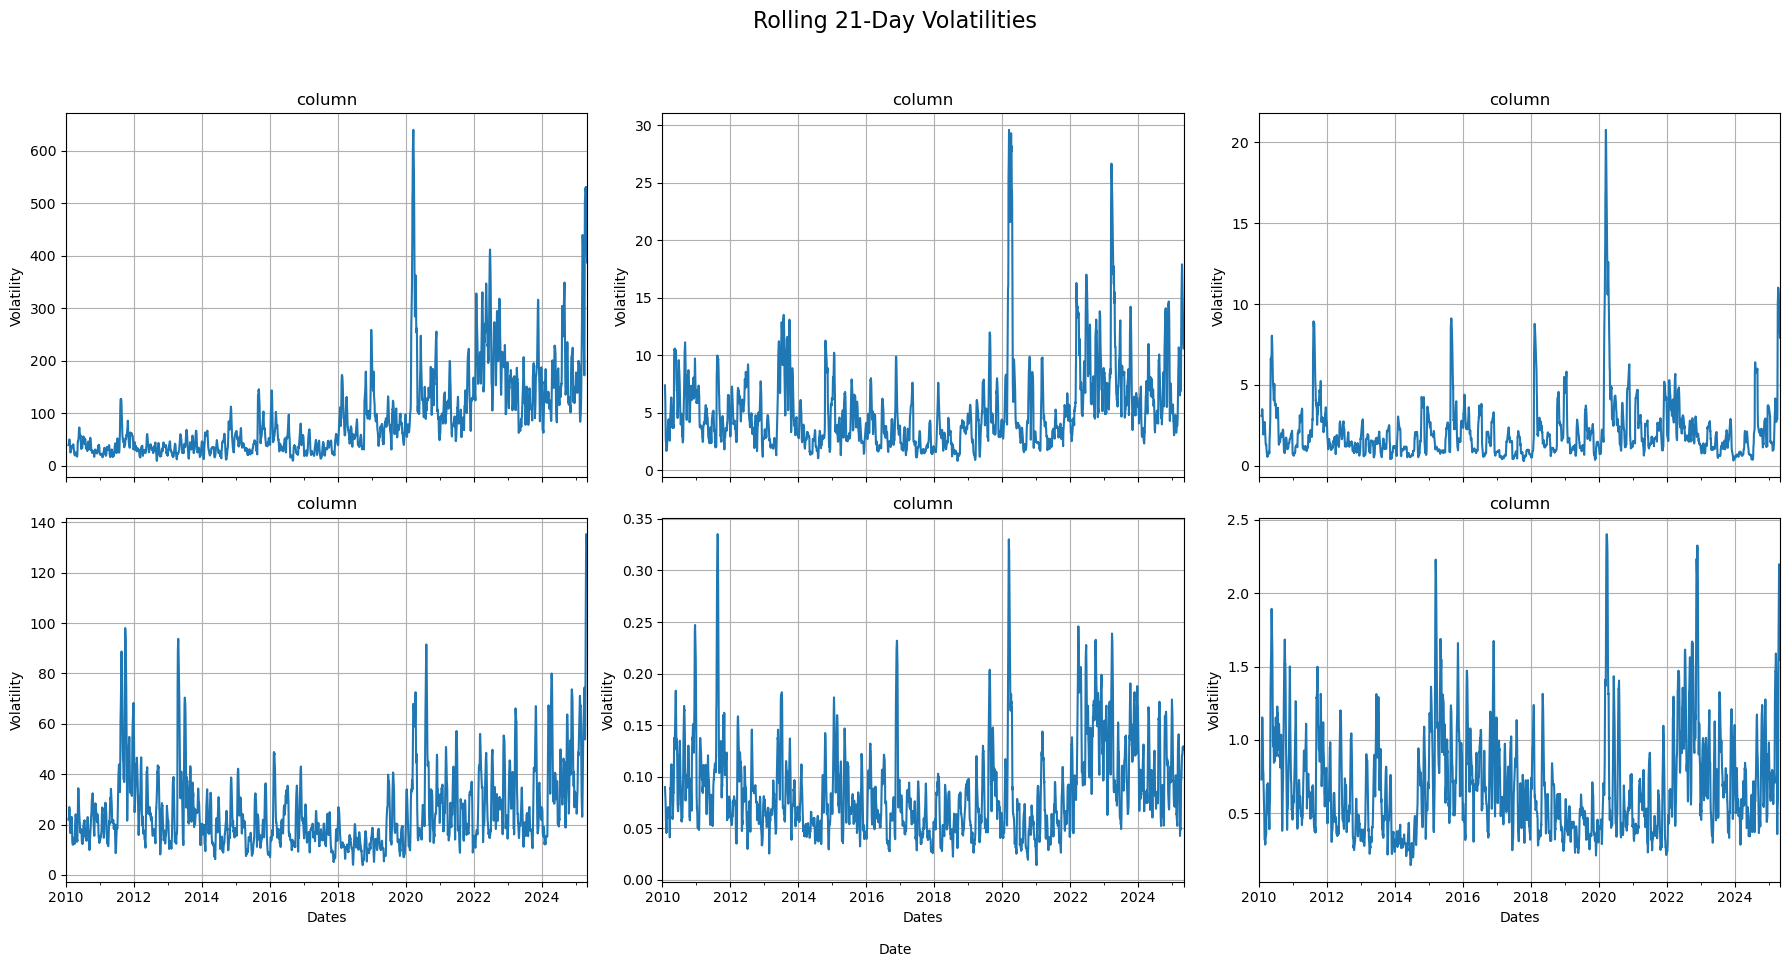

In [270]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharex=True)
fig.suptitle('Rolling 21-Day Volatilities', fontsize=16)
axes = axes.flatten()

assets_to_plot = df.columns

for i, column in enumerate(assets_to_plot):
    if i < len(axes):
        df[column].rolling(21).std().plot(ax=axes[i])
        axes[i].set_title("column")
        axes[i].set_ylabel("Volatility")
        axes[i].grid(True)

# Add common x-label if sharex=True
fig.text(0.5, 0.04, 'Date', ha='center', va='center')
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

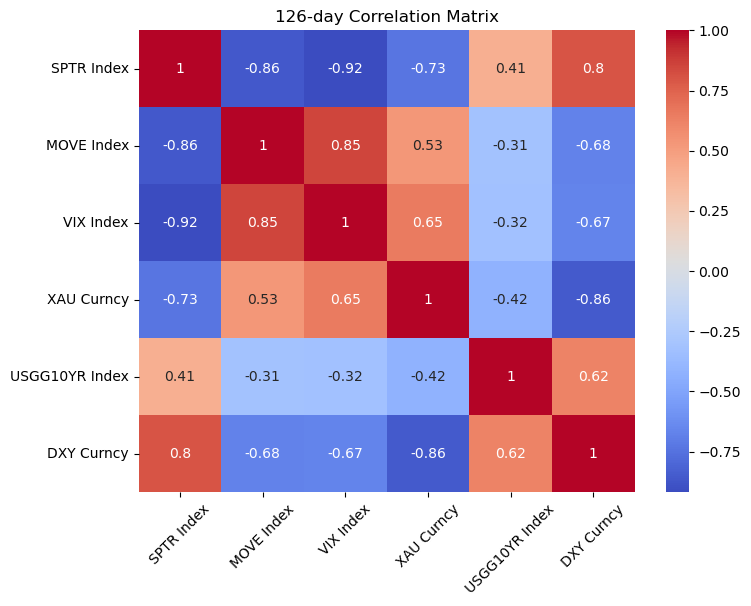

In [261]:
# Making the most recent 126-day correlation heatmap.
# Should I make it over the whole dataset? At the moment I took last 126-days.
corr_matrix = df[-126:].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    cbar=True,
    xticklabels=corr_matrix.columns,
    yticklabels=corr_matrix.columns
)
plt.title("126-day Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Detect market regimes

In [262]:
# Build a simple two state “risk-on / risk-off” model.

# 1) a Markov-switching model on realised S&P volatility or draw-downs
# TODO!

# 2) a transparent threshold rule (risk-off whenever VIX > 25 and MOVE > 100).
model_data2 = df.copy()

VIX_threshold = 25
MOVE_threshold = 100

# Risk on
model_data2["status"] = 0

# Risk off
risk_off = (model_data2["VIX Index"] > VIX_threshold) & (model_data2["MOVE Index"] > MOVE_threshold)
model_data2.loc[risk_off, "status"] = 1

print(model_data2)


            SPTR Index  MOVE Index  VIX Index  XAU Curncy  USGG10YR Index  \
Dates                                                                       
2010-01-01    1837.499      107.50      21.68     1097.35          3.8350   
2010-01-04    1867.063      106.40      20.04     1121.28          3.8155   
2010-01-05    1872.896      102.50      19.35     1118.05          3.7608   
2010-01-06    1874.729      106.90      19.16     1138.25          3.8215   
2010-01-07    1882.344      104.40      19.06     1131.75          3.8235   
...                ...         ...        ...         ...             ...   
2025-04-25   12178.492      105.79      24.84     3319.72          4.2353   
2025-04-28   12186.517      110.01      25.15     3343.98          4.2082   
2025-04-29   12257.272      112.27      24.17     3317.41          4.1716   
2025-04-30   12276.393      112.48      24.70     3288.71          4.1619   
2025-05-01   12353.874      107.33      24.60     3239.20          4.2176   

In [263]:
# Finding how many trading days there are in my data
trading_days_per_year = df.groupby(df.index.year).size()
average_trading_days = trading_days_per_year.mean()
print("Average trading days per year:", average_trading_days)

Average trading days per year: 250.0


In [264]:
# Loading prices in and making them to matrix.
prices = np.loadtxt("Data/processed_data.csv", delimiter=",", skiprows=1, usecols=(1,2,3,4,5,6))

T, n_assets = prices.shape #(T=4000,n_assets=6)

log_ret = np.diff(np.log(prices), axis=0)
dt = 1 / average_trading_days

# arith_ret[t] is the return from prices[t] to prices[t+1]
arith_ret = np.exp(log_ret) - 1.0
mu_arith_ann = arith_ret.mean(axis=0) * average_trading_days

tickers = ["SPTR", "MOVE", "VIX", "XAU", "US10Y", "DXY"]
for i, tkr in enumerate(tickers):
    print(tkr, "-> mu arith = ", mu_arith_ann[i])

SPTR -> mu arith =  0.1339145896100656
MOVE -> mu arith =  0.24048071914497468
VIX -> mu arith =  0.7753331276266044
XAU -> mu arith =  0.07910620678550699
US10Y -> mu arith =  0.10641443087763877
DXY -> mu arith =  0.018235066084245036


In [265]:
# Portfolio Simulation

initial_capital = 1.0

# Portfolio 1
portfolio_value_eq = np.zeros(T)
portfolio_value_eq[0] = initial_capital

# [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]
weights_eq = np.ones(n_assets) / n_assets

# Loop through each period
for t in range(T - 1):
    portfolio_period_return = np.sum(weights_eq * arith_ret[t, :])
    portfolio_value_eq[t+1] = portfolio_value_eq[t] * (1 + portfolio_period_return)

print("Portfolio 1 value at the end: ", portfolio_value_eq[-1])

# Portfolio 2
portfolio_value_regime = np.zeros(T)
portfolio_value_regime[0] = initial_capital

sptr_idx = 0
move_idx = 1
vix_idx = 2
xau_idx = 3
usgg10yr_idx = 4
dxy_idx = 5

# Loop through each period
for t in range(T - 1):
    current_vix_level = prices[t, vix_idx]
    current_move_level = prices[t, move_idx]

    weights_dyn = np.zeros(n_assets)

    if current_vix_level > 25 and current_move_level > 100:
        weights_dyn[usgg10yr_idx] = 0.50
        weights_dyn[xau_idx] = 0.25
        weights_dyn[sptr_idx] = 0
        weights_dyn[move_idx] = 0
        weights_dyn[vix_idx] = 0
        weights_dyn[dxy_idx] = 0
        # Remaining 25% is cash, what is earning 0% return in this model
    else:
        weights_dyn[sptr_idx] = 0.60
        weights_dyn[usgg10yr_idx] = 0.40
        weights_dyn[move_idx] = 0
        weights_dyn[vix_idx] = 0
        weights_dyn[xau_idx] = 0
        weights_dyn[dxy_idx] = 0

    portfolio_period_return = np.sum(weights_dyn * arith_ret[t, :])
    portfolio_value_regime[t+1] = portfolio_value_regime[t] * (1 + portfolio_period_return)

print("Portfolio 2 value at the end: ", portfolio_value_regime[-1])

Portfolio 1 value at the end:  22.16684726568571
Portfolio 2 value at the end:  4.366310802726284


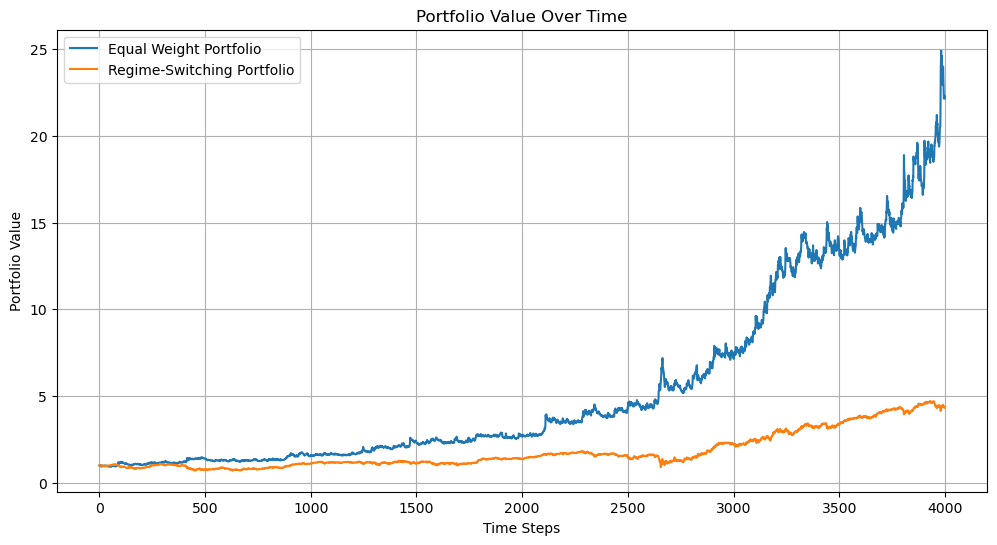

Equal weight portfolio results:
Annualized return:  19.371079059043993 %
Annualized volatility:  25.122583390162916 %
Sharpe ratio:  0.7710623847159364
--------------------------------------------------
Regime-switching portfolio results: 
Annualized return:  9.214293840079936 %
Annualized volatility:  22.91042270706742 %
Sharpe ratio:  0.4021878582466096


In [266]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value_eq, label="Equal Weight Portfolio")
plt.plot(portfolio_value_regime, label="Regime-Switching Portfolio")
plt.title("Portfolio Value Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)
plt.show()

# Metrics
# Equal Weight Portfolio
log_returns_eq = np.diff(np.log(portfolio_value_eq[portfolio_value_eq > 0]))
annualized_return_eq = np.mean(log_returns_eq) * average_trading_days
annualized_volatility_eq = np.std(log_returns_eq) * np.sqrt(average_trading_days)
sharpe_ratio_eq = annualized_return_eq / annualized_volatility_eq


print("Equal weight portfolio results:")
print("Annualized return: ", annualized_return_eq*100, "%")
print("Annualized volatility: ", annualized_volatility_eq*100, "%")
print("Sharpe ratio: ", sharpe_ratio_eq)

print("-"*50)

# Regime-switching portfolio
log_returns_regime = np.diff(np.log(portfolio_value_regime))
annualized_return_regime = np.mean(log_returns_regime) * average_trading_days
annualized_volatility_regime = np.std(log_returns_regime) * np.sqrt(average_trading_days)
sharpe_ratio_regime = annualized_return_regime / annualized_volatility_regime

print("Regime-switching portfolio results: ")
print("Annualized return: ", annualized_return_regime*100, "%")
print("Annualized volatility: ", annualized_volatility_regime*100, "%")
print("Sharpe ratio: ", sharpe_ratio_regime)

In [268]:
def max_drawdown(series):
    running_max = np.maximum.accumulate(series)
    drawdowns = (series - running_max) / running_max
    return drawdowns.min()


mdd_eq = max_drawdown(portfolio_value_eq)
mdd_reg = max_drawdown(portfolio_value_regime)

daily_returns_eq_portfolio = np.diff(portfolio_value_eq) / portfolio_value_eq[:-1]
daily_returns_regime_portfolio = np.diff(portfolio_value_regime) / portfolio_value_regime[:-1]

sptr_arith_returns = arith_ret[:, sptr_idx]

worst_sptr_days_indices = np.argsort(sptr_arith_returns)[:20]

portfolio_eq_on_worst_sptr_days = daily_returns_eq_portfolio[worst_sptr_days_indices]
portfolio_regime_on_worst_sptr_days = daily_returns_regime_portfolio[worst_sptr_days_indices]

avg_tail_eq = np.mean(portfolio_eq_on_worst_sptr_days)
avg_tail_reg = np.mean(portfolio_regime_on_worst_sptr_days)

print("Equal-Weight Portfolio")
print("Max Draw-down: ", mdd_eq * 100)
print("Avg. worst-20 days: ", avg_tail_eq * 100)
print("-" * 40)
print("Regime-Switch Portfolio")
print("Max Draw-down: ", mdd_reg * 100)
print("Avg. worst-20 days: ", avg_tail_reg * 100)

Equal-Weight Portfolio
Max Draw-down:  -28.018778271156364
Avg. worst-20 days:  4.4594726221704555
----------------------------------------
Regime-Switch Portfolio
Max Draw-down:  -50.89673007521955
Avg. worst-20 days:  -4.629103710360467


**Summary for CIO**

**Topic**: Cross-Asset Portfolio Strategy Review 2010-2025

Evaluated a static Equal Weight portfolio against a simple VIX/MOVE threshold based Regime-Switching strategy to assess performance and risk characteristics.

**Regime Model (RS Strategy):**

*   **Risk-Off Trigger:** VIX > 25 **AND** MOVE > 100
*   **Risk-On Allocation:** 60% S&P 500 | 40% 10-Yr US Treasuries
*   **Risk-Off Allocation:** 50% 10-Yr US Treasuries | 25% Gold | 25% Cash

**Equal Weight Portfolio**: SPTR, MOVE, VIX, XAU, USGG10YR, DXY - equally weighted

**Performance Highlights**

| Metric                                    | Equal Weight (EW) | Regime-Switching (RS) |
| :---------------------------------------- | :---------------- | :-------------------- |
| **Annualized Return**                     | 19.37%            | 9.49%                 |
| **Annualized Volatility**                 | 25.12%            | 23.36%                |
| **Sharpe Ratio**                          | 0.77              | 0.41                  |
| **Max Drawdown**                          | -28.02%           | -51.24%               |
| **Avg. Perf. on S&P's 20 Worst Days**     | +4.46%            | -5.10%                |

The static Equal Weight portfolio significantly outperformed the tested Regime-Switching strategy. The specific VIX/MOVE threshold rule and the chosen asset allocations for the Regime switching strategy did not provide the intended benefits over this period.







